# Data Wrangling - WeRateDogs

> Project initiative aims at covering fundamental steps before crunching data: Data wrangling.
It emcompasses many tasks, very often tedious ones. But all necessary to carry on with proper data analysis.

>Primarly, collecting the data we need from multiple sources and different fashions. Then, assessing it vizually and progammatically to identify potential pitfalls and apply all transformations that would ease the remaining steps of the process.
>Finally, go through the different data collected, either via relevant vizualizations and/or programmatic methods to get the essence of it and hopefully find the answers to our initial questions.





## Table of Contents

* [1.Gather](#gather)
    * [1.1 Read original file(.csv)](#readcsv)
        
    * [1.2 Read from Twitter api](#readapi)
        * [1.2.1 Configure credentials for API](#apicredentials)
        * [1.2.2 Query Tweeter API & store results (json) in file](#queryapi)
        * [1.2.3 Read json file content in a dataframe](#readjson)
        
    * [1.3 Read from image predictions file](#readimg)
        * [1.3.1 Download file & save results as .tsv file](#savetsv)   


* [2.Assessment](#assess)
    * [2.1 Assess original file(csv)](#assessoriginalecsv)
    * [2.2 Report - original file](#reportoriginalcsv)
    * [2.3 Assess image predictions file](#assessimgpreds)
    * [2.4 Report - image predictions file assesment](#reportimgpreds)
    * [2.5 Assess json data in dataframe](#assessjson)
    * [2.6 Report - json data assesment](#reportjson)
    
    
* [3.Cleaning](#clean)
    * [3.1 Cleaning tasks - json](#cleanjson)
    * [3.2 Cleaning tasks - image predictions](#cleanpreds)
    
    
* [4. Storing, Analyzing & Vizualizing wrangled data](#results)
    * [4.1 Generate output file(s) after wrangled efforts](#wrangled_files)
    * [4.2 Vizualization & Insights on wrangled data](#insights)

To get started, let's import our libraries.

In [1]:
# install dependencies 
import pandas as pd
import numpy as np
import requests
import os
import json
import tweepy
import datetime as dt
from timeit import default_timer as timer
import matplotlib.pyplot as plt


%matplotlib inline
#pip install tweepy

<a id='gather'></a>
## 1.Gather

<a id='readcsv'></a>
### 1.1 Read original file (.csv)

In [2]:
df = pd.read_csv('twitter-archive-enhanced.csv')
print(df.shape)
df.head(2)


(2356, 17)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [3]:
# as required in keypoints - we only need infos for original tweets, retweets have to be removed
df_original_tweets = df[df['retweeted_status_id'].isnull()]
df_original_tweets.sample(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2273,667470559035432960,NaN,NaN,2015-11-19 22:32:36 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",This is a northern Wahoo named Kohl. He runs t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667470559...,11,10,a,None,None,None,None
49,882762694511734784,NaN,NaN,2017-07-06 00:46:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Gus. He's quite the cheeky pupper. Alr...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/882762694...,12,10,Gus,None,None,pupper,None


<a id='readapi'></a>
### 1.2 Read from Twitter API (tweepy)

<a id='apicredentials'></a>
##### 1.2.1 Configure credentials for API -- (No need to run the code in cell)

In [4]:
# credentials to query twitter api (REMOVED BEFORE SUBMISSION)
consumer_key = '{user-consumer-key}'
consumer_secret = '{user-consumer-secret}'
access_token = '{user-access-token}'
access_secret = '{user-access-secret}'


auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

# set the wait on rate limit to avoid cancellation
api = tweepy.API(auth,wait_on_rate_limit=True)

In [5]:
#api.get_status(754120377874386944, tweet_mode='extended')
len (df_original_tweets) 

2175

<a id='queryapi'></a>
##### 1.2.2 Query Tweeter API & store results (json) in file

In [7]:
# def a function that can read from any dataframe and return a list of tweet_id - Input required
def get_tweet_id(df_original_tweets):
    tweet_id_list = df_original_tweets['tweet_id']
    return tweet_id_list


# def a function (no input required) that will:
#(a) read list of tweet_id
#(b) get api data for specific tweet_id 
#(c) store the result as json in .txt file
#(d) store any possible exceptions returned from api (ie.deleted tweets)

errors_dict = {}

def get_tweetid_content():
    tweet_id_list = get_tweet_id(df_original_tweets)
    start = timer()
    with open('tweet_json.txt', 'w') as file:
        for tweet_id in tweet_id_list:
            try:
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                tweet_content = tweet._json
                #return tweet_content
                json.dump(tweet_content, file)
                file.write('\n')
                
            except tweepy.TweepError as e:
                errors_dict[tweet_id] = e
    end = timer()
    print(end - start)
    #print(errors_dict)

get_tweetid_content()

1933.3210559780127


In [8]:
# check for errors - missing tweet_id
errors_dict

{872261713294495745: tweepy.error.TweepError([{'code': 144,
                           'message': 'No status found with that ID.'}]),
 844704788403113984: tweepy.error.TweepError([{'code': 144,
                           'message': 'No status found with that ID.'}]),
 837366284874571778: tweepy.error.TweepError([{'code': 144,
                           'message': 'No status found with that ID.'}]),
 829374341691346946: tweepy.error.TweepError([{'code': 144,
                           'message': 'No status found with that ID.'}]),
 779123168116150273: tweepy.error.TweepError([{'code': 144,
                           'message': 'No status found with that ID.'}]),
 754011816964026368: tweepy.error.TweepError([{'code': 144,
                           'message': 'No status found with that ID.'}]),
 680055455951884288: tweepy.error.TweepError([{'code': 144,
                           'message': 'No status found with that ID.'}])}

<a id='readjson'></a>
##### 1.2.3 Read json file content in a dataframe

In [9]:
# open file with content saved as json for - each line corresponding to one tweet
with open('tweet_json.txt') as f:
    df_tweet_api = pd.DataFrame(json.loads(line) for line in f)
    
df_tweet_api.head(2)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,35148,False,False,False,False,en,NaN,NaN,NaN,NaN
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,892177421306343426,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,30415,False,False,False,False,en,NaN,NaN,NaN,NaN


In [10]:
# losing 7 tweets as missing in api response
df_tweet_api.shape

(2168, 31)

In [11]:
# select only the cols we need for our analysis
df_tweet_api = df_tweet_api.iloc[:, [0,1,2,3,8,14,20,21,22,23]].copy()


# check if subset operation maintain same num of rows
len(df_tweet_api)

2168

In [12]:
df_tweet_api.head()

,created_at,id,id_str,full_text,source,user,retweet_count,favorite_count,favorited,retweeted
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na...",7413,35148,False,False
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,892177421306343426,This is Tilly. She's just checking pup on you....,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na...",5515,30415,False,False
2,Mon Jul 31 00:18:03 +0000 2017,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na...",3640,22856,False,False
3,Sun Jul 30 15:58:51 +0000 2017,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na...",7591,38426,False,False
4,Sat Jul 29 16:00:24 +0000 2017,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na...",8163,36683,False,False


<a id='readimg'></a>
### 1.3 Read from image predictions file

<a id='savetsv' ></a>
##### 1.3.1 Download file & save results as .tsv file

In [39]:
# url where file is located was provided - Download file using requets library
folder_name='/Users/samy.bencherif/Documents/udacity_courses/ND_data_analyst/ND_data_wrangling'
img_preds_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
download_file = requests.get(img_preds_url)
file_content = download_file.content

with open (os.path.join(folder_name,img_preds_url.split('/')[-1]),mode='wb') as file:
    file.write(file_content)
    

In [40]:
df_img_preds = pd.read_csv("image-predictions.tsv",sep='\t')
df_img_preds.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


<a id='assess'></a>
# 2. Assessment

3 files have to be assesed
csv provided initially (df_original_tweets) -- we know this one was extracted via api but was missing some useful infos and contain useless data (retweet) hence we can direcly use the one obtained via api later and discard this one from our investigation.
tsv downloaded from server (df_img_preds)
json obtained with twitter api (df_api)

<a id='assessoriginalecsv'></a>
### 2.1 Assess original file ('twitter-archive-enhanced.csv')

In [41]:
df_original_tweets.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


<a id='reportoriginalcsv'></a>
### 2.2 Report - original file
1. we know this one was extracted via api but was missing some useful infos and contain useless data (retweet) hence we can direcly use the one obtained via api later and discard this one from our investigation

<a id='assessimgpreds'></a>
### 2.3 Assess image prediction file ('image-predictions.tsv')

In [42]:
df_img_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [43]:
df_img_preds[df_img_preds.duplicated(['jpg_url'], keep=False)].tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1970,868880397819494401,https://pbs.twimg.com/media/DA7iHL5U0AA1OQo.jpg,1,laptop,0.153718,False,French_bulldog,0.099984,True,printer,0.077130,False
1992,873697596434513921,https://pbs.twimg.com/media/DA7iHL5U0AA1OQo.jpg,1,laptop,0.153718,False,French_bulldog,0.099984,True,printer,0.077130,False
2041,885311592912609280,https://pbs.twimg.com/media/C4bTH6nWMAAX_bJ.jpg,1,Labrador_retriever,0.908703,True,seat_belt,0.057091,False,pug,0.011933,True
2051,887473957103951883,https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg,2,Pembroke,0.809197,True,Rhodesian_ridgeback,0.054950,True,beagle,0.038915,True
2055,888202515573088257,https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg,2,Pembroke,0.809197,True,Rhodesian_ridgeback,0.054950,True,beagle,0.038915,True


<a id='reportimgpreds'></a>
### 2.4 Report - image predictions file assesment
1. tweet_id not named the same as in df_api. keep 'tweet_id' as it's clearer. Change made in file retrived via api
2. p1,p2,p3 column mixes low and upper case values
3. p1 and p2 return inaccurate predictions (paper towel,orange,etc..)
4. rename pn, pn_conf and pn_dog for clarity
5. predictions could be stored as 1 variable with 3 labels (algo1,algo2,algo3)
6. jpg_url returns duplicates for distint tweet_id - need to get clean data from from df_api 

<a id='assessjson'></a>
### 2.5 Assess json data in dataframe

In [44]:
df_tweet_api.source

0       <a href="http://twitter.com/download/iphone" r...
1       <a href="http://twitter.com/download/iphone" r...
2       <a href="http://twitter.com/download/iphone" r...
3       <a href="http://twitter.com/download/iphone" r...
4       <a href="http://twitter.com/download/iphone" r...
                              ...                        
2163    <a href="http://twitter.com/download/iphone" r...
2164    <a href="http://twitter.com/download/iphone" r...
2165    <a href="http://twitter.com/download/iphone" r...
2166    <a href="http://twitter.com/download/iphone" r...
2167    <a href="http://twitter.com/download/iphone" r...
Name: source, Length: 2168, dtype: object

In [45]:
df_tweet_api.head()

,created_at,id,id_str,full_text,source,user,retweet_count,favorite_count,favorited,retweeted
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na...",7413,35148,False,False
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,892177421306343426,This is Tilly. She's just checking pup on you....,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na...",5515,30415,False,False
2,Mon Jul 31 00:18:03 +0000 2017,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na...",3640,22856,False,False
3,Sun Jul 30 15:58:51 +0000 2017,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na...",7591,38426,False,False
4,Sat Jul 29 16:00:24 +0000 2017,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,"<a href=""http://twitter.com/download/iphone"" r...","{'id': 4196983835, 'id_str': '4196983835', 'na...",8163,36683,False,False


In [46]:
df_tweet_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2168 entries, 0 to 2167
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   created_at      2168 non-null   object
 1   id              2168 non-null   int64 
 2   id_str          2168 non-null   object
 3   full_text       2168 non-null   object
 4   source          2168 non-null   object
 5   user            2168 non-null   object
 6   retweet_count   2168 non-null   int64 
 7   favorite_count  2168 non-null   int64 
 8   favorited       2168 non-null   bool  
 9   retweeted       2168 non-null   bool  
dtypes: bool(2), int64(3), object(5)
memory usage: 139.9+ KB


<a id='reportjson'></a>
### 2.6 Report - json assesment
1. created_ad stored as timestamp - need to cast for analysis purpose
2. id and id_str columns are duplicates
3. rating does not seem accurate - get it from data fetched via api
4. rename 'media url' column for consistency with image predictions file and make it clear it refers to image url
5. rename 'favorited' to make it clear it's a boolean
6. rename 'id' to make it cleat it refers to tweet_id

<a id='clean'></a>
# 3. Cleaning

<a id='cleanjson'></a>
### 3.1 Cleaning tasks - json
1. gather in clean json only the data we will need for out analysis - filter out irrelevant fields.
2. format 'created_date' as date
3. get accurate rating from 'full_text'
4. keep only on tweet id. 'id' and 'id_str' are duplicated fields 
5. filter out 'favorited - 'values for column 'favorited' set in false while favorite_count is greater than 0
6. get 'user id' from nested dictionnary - in case it can be used for our analysis
7. rename 'id' column label for clarity and consistency with other datasets
8. rename 'media_url'column label for clarity and consistency with other datasets
9. rename 'favorited' to make it clear it's a boolean

1. Clean json - keep only data we will need for analysis

In [47]:
df_tweet_api_clean = []
with open('tweet_json.txt', 'r') as json_file:
    for line in json_file:
        json_data = json.loads(line)
        
        try:
          media_url = json_data['entities']['media'][0]['expanded_url']
        except Exception as e:
          media_url = ""
        
        df_tweet_api_clean.append({ 'created_at': json_data['created_at'],
                                    'tweet_id': json_data['id'],
                                    'full_text': json_data['full_text'],
                                    'favorites_cnt': json_data['favorite_count'],
                                    'retweets_cnt' : json_data['retweet_count'],
                                    'user_id' : json_data['user']['id'],
                                    'source': json_data['source'], 
                                    'img_url' : media_url,
                                    'is_favorite': json_data['favorited']
                                  })
                        
df_tweet_api_clean = pd.DataFrame(df_tweet_api_clean, columns=['created_at','tweet_id','full_text','favorites_cnt',
                                                               'retweets_cnt','is_favorited','user_id','source','img_url'])

In [48]:
len(df_tweet_api_clean.is_favorited.isnull())

2168

In [49]:
df_tweet_api_clean.head()

,created_at,tweet_id,full_text,favorites_cnt,retweets_cnt,is_favorited,user_id,source,img_url
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,35148,7413,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892420643...
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,This is Tilly. She's just checking pup on you....,30415,5515,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892177421...
2,Mon Jul 31 00:18:03 +0000 2017,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,22856,3640,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891815181...
3,Sun Jul 30 15:58:51 +0000 2017,891689557279858688,This is Darla. She commenced a snooze mid meal...,38426,7591,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891689557...
4,Sat Jul 29 16:00:24 +0000 2017,891327558926688256,This is Franklin. He would like you to stop ca...,36683,8163,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891327558...


2. Format to date 'created_at'

In [50]:
df_tweet_api_clean['time'] = pd.to_datetime(df_tweet_api_clean['created_at'])
df_tweet_api_clean['creation_date'] = df_tweet_api_clean['time'].dt.date

df_tweet_api_clean.head()


,created_at,tweet_id,full_text,favorites_cnt,retweets_cnt,is_favorited,user_id,source,img_url,time,creation_date
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,35148,7413,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892420643...,2017-08-01 16:23:56+00:00,2017-08-01
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,This is Tilly. She's just checking pup on you....,30415,5515,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892177421...,2017-08-01 00:17:27+00:00,2017-08-01
2,Mon Jul 31 00:18:03 +0000 2017,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,22856,3640,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891815181...,2017-07-31 00:18:03+00:00,2017-07-31
3,Sun Jul 30 15:58:51 +0000 2017,891689557279858688,This is Darla. She commenced a snooze mid meal...,38426,7591,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891689557...,2017-07-30 15:58:51+00:00,2017-07-30
4,Sat Jul 29 16:00:24 +0000 2017,891327558926688256,This is Franklin. He would like you to stop ca...,36683,8163,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891327558...,2017-07-29 16:00:24+00:00,2017-07-29


In [51]:
# remove unused date columns
df_tweet_api_clean = df_tweet_api_clean.drop(['time','created_at'],axis=1)

In [52]:

df_tweet_api_clean.head(2)

,tweet_id,full_text,favorites_cnt,retweets_cnt,is_favorited,user_id,source,img_url,creation_date
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,35148,7413,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892420643...,2017-08-01
1,892177421306343426,This is Tilly. She's just checking pup on you....,30415,5515,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892177421...,2017-08-01


3. Get accurate rating from 'full_text'

In [53]:
df_rating_clean = df_tweet_api_clean.full_text.str.extract(r'((?:\d+\.)?\d+)\/(\d+)',expand=True)
df_tweet_api_clean['rating_numerator'] = df_rating_clean[0]
df_tweet_api_clean['rating_denominator'] = df_rating_clean[1]


In [54]:
df_tweet_api_clean.head()

,tweet_id,full_text,favorites_cnt,retweets_cnt,is_favorited,user_id,source,img_url,creation_date,rating_numerator,rating_denominator
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,35148,7413,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892420643...,2017-08-01,13,10
1,892177421306343426,This is Tilly. She's just checking pup on you....,30415,5515,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892177421...,2017-08-01,13,10
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,22856,3640,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891815181...,2017-07-31,12,10
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,38426,7591,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891689557...,2017-07-30,13,10
4,891327558926688256,This is Franklin. He would like you to stop ca...,36683,8163,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891327558...,2017-07-29,12,10


In [55]:
df_tweet_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2168 entries, 0 to 2167
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2168 non-null   int64  
 1   full_text           2168 non-null   object 
 2   favorites_cnt       2168 non-null   int64  
 3   retweets_cnt        2168 non-null   int64  
 4   is_favorited        0 non-null      float64
 5   user_id             2168 non-null   int64  
 6   source              2168 non-null   object 
 7   img_url             2168 non-null   object 
 8   creation_date       2168 non-null   object 
 9   rating_numerator    2168 non-null   object 
 10  rating_denominator  2168 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 186.4+ KB


<a id='cleanpreds'></a>
### 3.2 Cleaning tasks - image predictions


1. tweet_id not named the same as in df_api. keep 'tweet_id' as its clearer and change name in api file
2. store predictions as 1 variable populated with 3 labels (algo1,algo2,algo3)
3. format p1,p2,p3 values to fix lower/upper case inconsistency
4. get accurate predictions data for p1 and p2 (paper towel,orange,etc..) - can't do
5. rename pn, pn_conf and pn_dog for clarity
6. drop jpg_url as it returns duplicate image for distinct tweet_id
7. replace jpg_url with real image_url - get it from api fetched data.
8. rename jpg_url for image_url for consistency with other datasets

In [56]:
# Display preview image prediction file 
df_img_preds.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [57]:
# Make a copy (clean) where we ll perform cleansing operations
df_img_preds_clean = df_img_preds.copy()
len(df_img_preds_clean)

2075

 2. Store predictions as 1 variable populated with 3 labels (algo1,algo2,algo3)


In [58]:
# Create 1 new col/variable named 'algorithm' that will return values for p1,p2 and p3
df_melt_algo = pd.melt(df_img_preds_clean, id_vars=['tweet_id', 'jpg_url','img_num','p1_conf','p1_dog'
                                                         ,'p2_conf','p2_dog','p3_conf','p3_dog']
                    ,var_name='algorithm', value_vars=['p1','p2','p3'],value_name='predictions')

df_melt_algo

,tweet_id,jpg_url,img_num,p1_conf,p1_dog,p2_conf,p2_dog,p3_conf,p3_dog,algorithm,predictions
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,0.465074,True,0.156665,True,0.061428,True,p1,Welsh_springer_spaniel
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,0.506826,True,0.074192,True,0.072010,True,p1,redbone
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,0.596461,True,0.138584,True,0.116197,True,p1,German_shepherd
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,0.408143,True,0.360687,True,0.222752,True,p1,Rhodesian_ridgeback
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,0.560311,True,0.243682,True,0.154629,True,p1,miniature_pinscher
...,...,...,...,...,...,...,...,...,...,...,...
6220,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,0.555712,True,0.225770,True,0.175219,True,p3,German_short-haired_pointer
6221,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,0.170278,False,0.168086,True,0.040836,False,p3,spatula
6222,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,0.716012,True,0.078253,True,0.031379,True,p3,kelpie
6223,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,0.323581,True,0.090647,True,0.068957,True,p3,papillon


In [59]:
# Create 1 new col/variable named 'algo_confidence' that will return values for p1_conf,p2_conf and p3_conf
df_melt_conf = pd.melt(df_img_preds_clean, id_vars=['tweet_id'],
                    value_vars=['p1_conf','p2_conf','p3_conf'],value_name='algo_confidence')
df_melt_conf

,tweet_id,variable,algo_confidence
0,666020888022790149,p1_conf,0.465074
1,666029285002620928,p1_conf,0.506826
2,666033412701032449,p1_conf,0.596461
3,666044226329800704,p1_conf,0.408143
4,666049248165822465,p1_conf,0.560311
...,...,...,...
6220,891327558926688256,p3_conf,0.175219
6221,891689557279858688,p3_conf,0.040836
6222,891815181378084864,p3_conf,0.031379
6223,892177421306343426,p3_conf,0.068957


5. Rename pn, pn_conf and pn_dog for clarity

In [60]:
# Create 1 new col/variable named 'preds_is_dog' that will return values for p1_dog,p2_dog and p3_dog
df_melt_isdog = pd.melt(df_img_preds_clean, id_vars=['tweet_id'],
                     value_vars=['p1_dog','p2_dog','p3_dog'],value_name='preds_is_dog')
df_melt_isdog

,tweet_id,variable,preds_is_dog
0,666020888022790149,p1_dog,True
1,666029285002620928,p1_dog,True
2,666033412701032449,p1_dog,True
3,666044226329800704,p1_dog,True
4,666049248165822465,p1_dog,True
...,...,...,...
6220,891327558926688256,p3_dog,True
6221,891689557279858688,p3_dog,False
6222,891815181378084864,p3_dog,True
6223,892177421306343426,p3_dog,True


In [61]:
# Merge the 3 subsets into 1 single clean dataframe and remove unnecessary columns
df_img_preds_clean = pd.merge(df_melt_algo, df_melt_conf , left_index=True, right_index=True)
df_img_preds_clean = pd.merge(df_img_preds_clean,df_melt_isdog, left_index=True, right_index=True)
df_img_preds_clean = df_img_preds_clean.drop(['tweet_id_x','p1_conf','p1_dog','p2_conf','p2_dog','p3_dog','p3_conf','tweet_id_y','variable_x'
                        ,'variable_y'],axis=1)

In [62]:
# Check for new shape of data frame 
df_img_preds_clean.head()
print(df_img_preds.shape,df_img_preds_clean.shape)

(2075, 12) (6225, 7)


> As the result of restructuring our data, it is expected to see our number of rows increased by 3x.
Indeed, original DataFrame returns 2075 rows to be multiplied by 3 values (p1,p2,p3) that used to be shown as separate columns.
Less columns is the result of us dropping unnecessary ones.

2. Format p1,p2,p3 values to fix lower/upper case inconsistency

In [63]:
# Cast predictions values to lowercase - before is a mix or low/upper case
df_img_preds_clean['predictions'] = df_img_preds_clean['predictions'].str.lower()
df_img_preds_clean.head()

,jpg_url,img_num,algorithm,predictions,algo_confidence,tweet_id,preds_is_dog
0,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,p1,welsh_springer_spaniel,0.465074,666020888022790149,True
1,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,p1,redbone,0.506826,666029285002620928,True
2,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,p1,german_shepherd,0.596461,666033412701032449,True
3,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,p1,rhodesian_ridgeback,0.408143,666044226329800704,True
4,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,p1,miniature_pinscher,0.560311,666049248165822465,True


 6 & 7 & 8 drop jpg_url (duplicate image) & replace it with real image_url (api data) & rename the column

In [64]:
# Duplicate jpg_url detected for different tweet id
df_img_preds_clean[df_img_preds_clean.duplicated(['jpg_url'], keep=False)].tail()

,jpg_url,img_num,algorithm,predictions,algo_confidence,tweet_id,preds_is_dog
6220,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,p3,german_short-haired_pointer,0.175219,891327558926688256,True
6221,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,p3,spatula,0.040836,891689557279858688,False
6222,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,p3,kelpie,0.031379,891815181378084864,True
6223,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,p3,papillon,0.068957,892177421306343426,True
6224,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,p3,banana,0.076110,892420643555336193,False


In [65]:
# Merge image prediction file with api data using tweet_id as key to fetch real img url

df_tweet_api_clean_img = df_tweet_api_clean[['tweet_id','img_url']]

df_img_preds_clean = pd.merge(df_img_preds_clean ,df_tweet_api_clean_img , on=['tweet_id'], how='left')

# Remove old jpg_url column
df_img_preds_clean = df_img_preds_clean.drop('jpg_url',axis=1)

In [66]:
df_img_preds_clean.head()

,img_num,algorithm,predictions,algo_confidence,tweet_id,preds_is_dog,img_url
0,1,p1,welsh_springer_spaniel,0.465074,666020888022790149,True,https://twitter.com/dog_rates/status/666020888...
1,1,p1,redbone,0.506826,666029285002620928,True,https://twitter.com/dog_rates/status/666029285...
2,1,p1,german_shepherd,0.596461,666033412701032449,True,https://twitter.com/dog_rates/status/666033412...
3,1,p1,rhodesian_ridgeback,0.408143,666044226329800704,True,https://twitter.com/dog_rates/status/666044226...
4,1,p1,miniature_pinscher,0.560311,666049248165822465,True,https://twitter.com/dog_rates/status/666049248...


In [67]:
df_tweet_api_clean.head()

,tweet_id,full_text,favorites_cnt,retweets_cnt,is_favorited,user_id,source,img_url,creation_date,rating_numerator,rating_denominator
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,35148,7413,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892420643...,2017-08-01,13,10
1,892177421306343426,This is Tilly. She's just checking pup on you....,30415,5515,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892177421...,2017-08-01,13,10
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,22856,3640,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891815181...,2017-07-31,12,10
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,38426,7591,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891689557...,2017-07-30,13,10
4,891327558926688256,This is Franklin. He would like you to stop ca...,36683,8163,NaN,4196983835,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891327558...,2017-07-29,12,10


### At the end, we end up with:
> df_tweet_api_clean: fetch tweet infos from tweepy for tweetid provided in original file. Data from api is only for original tweets and filtered for columns only that we ll need for the rest of the analysis.

> df_img_preds_clean: that was reshaped to solve tidiness issue and updated with most accurate data fetched we got from twitter api

In [68]:
# Check for duplicates in df we are about to merge
df_tweet_api_clean_dups = df_tweet_api_clean[df_tweet_api_clean.duplicated()]
print(df_tweet_api_clean_dups)

df_img_preds_clean_dups = df_img_preds_clean[df_img_preds_clean.duplicated()]
print(df_img_preds_clean_dups)



Empty DataFrame
Columns: [tweet_id, full_text, favorites_cnt, retweets_cnt, is_favorited, user_id, source, img_url, creation_date, rating_numerator, rating_denominator]
Index: []
Empty DataFrame
Columns: [img_num, algorithm, predictions, algo_confidence, tweet_id, preds_is_dog, img_url]
Index: []


<a id='results'></a>
# 4. Storing, Analyzing, and Visualizing wrangled data

<a id='wrangled_files' ></a>
### 4.1 Generate output file(s) after wrangled efforts

In [69]:
# Keep only the prediction with best algorithm confidence
df_img_preds_clean_algo = df_img_preds_clean.sort_values(by=['tweet_id','algo_confidence'],ascending=True).drop_duplicates(subset=['tweet_id'],keep='last')


In [70]:
# See the dataset ordered by tweetid - 1 tweet can get up to 3 predictions.
df_img_preds_clean.sort_values(by='tweet_id')

,img_num,algorithm,predictions,algo_confidence,tweet_id,preds_is_dog,img_url
0,1,p1,welsh_springer_spaniel,0.465074,666020888022790149,True,https://twitter.com/dog_rates/status/666020888...
4150,1,p3,shetland_sheepdog,0.061428,666020888022790149,True,https://twitter.com/dog_rates/status/666020888...
2075,1,p2,collie,0.156665,666020888022790149,True,https://twitter.com/dog_rates/status/666020888...
1,1,p1,redbone,0.506826,666029285002620928,True,https://twitter.com/dog_rates/status/666029285...
4151,1,p3,rhodesian_ridgeback,0.072010,666029285002620928,True,https://twitter.com/dog_rates/status/666029285...
...,...,...,...,...,...,...,...
4148,1,p2,pekinese,0.090647,892177421306343426,True,https://twitter.com/dog_rates/status/892177421...
2073,1,p1,chihuahua,0.323581,892177421306343426,True,https://twitter.com/dog_rates/status/892177421...
2074,1,p1,orange,0.097049,892420643555336193,False,https://twitter.com/dog_rates/status/892420643...
4149,1,p2,bagel,0.085851,892420643555336193,False,https://twitter.com/dog_rates/status/892420643...


In [71]:
# Merge final datasets 
df_twitter_archive_master = df_tweet_api_clean.merge(df_img_preds_clean_algo, on=['tweet_id','img_url'], how="right")

# Remove user_id and is_favorites since does not bring relevant infos for the analysis
df_twitter_archive_master = df_twitter_archive_master.drop(df_twitter_archive_master.columns[[4,5]],axis=1)
df_twitter_archive_master.head()


,tweet_id,full_text,favorites_cnt,retweets_cnt,source,img_url,creation_date,rating_numerator,rating_denominator,img_num,algorithm,predictions,algo_confidence,preds_is_dog
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,35148.0,7413.0,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892420643...,2017-08-01,13,10,1,p1,orange,0.097049,False
1,892177421306343426,This is Tilly. She's just checking pup on you....,30415.0,5515.0,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/892177421...,2017-08-01,13,10,1,p1,chihuahua,0.323581,True
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,22856.0,3640.0,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891815181...,2017-07-31,12,10,1,p1,chihuahua,0.716012,True
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,38426.0,7591.0,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891689557...,2017-07-30,13,10,1,p1,paper_towel,0.170278,False
4,891327558926688256,This is Franklin. He would like you to stop ca...,36683.0,8163.0,"<a href=""http://twitter.com/download/iphone"" r...",https://twitter.com/dog_rates/status/891327558...,2017-07-29,12,10,2,p1,basset,0.555712,True


In [72]:
# Generate csv
df_twitter_archive_master.to_csv('twitter_archive_master.csv')

# in case it's necessary - both substets are also available separately

df_tweet_api_clean.to_csv('twitter_archive_wrangled.csv')

# equivalent to a 'predictions' table - it contains all predictions made. Not just the one with greatest 
#confidence score, since 1 tweet can have multiple entries

df_img_preds_clean.to_csv('image_predictions_wrangled.csv')
df_img_preds_clean_algo.to_csv('image_predictions_wrangled_algo.csv')



In [73]:
# Check if wrangled dataset respects wrangling operations
df_twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2075 non-null   int64  
 1   full_text           1987 non-null   object 
 2   favorites_cnt       1987 non-null   float64
 3   retweets_cnt        1987 non-null   float64
 4   source              1987 non-null   object 
 5   img_url             1987 non-null   object 
 6   creation_date       1987 non-null   object 
 7   rating_numerator    1987 non-null   object 
 8   rating_denominator  1987 non-null   object 
 9   img_num             2075 non-null   int64  
 10  algorithm           2075 non-null   object 
 11  predictions         2075 non-null   object 
 12  algo_confidence     2075 non-null   float64
 13  preds_is_dog        2075 non-null   bool   
dtypes: bool(1), float64(3), int64(2), object(8)
memory usage: 229.0+ KB


<a id='insights' ></a>
### 4.2 Vizualization & Insights on wrangled data

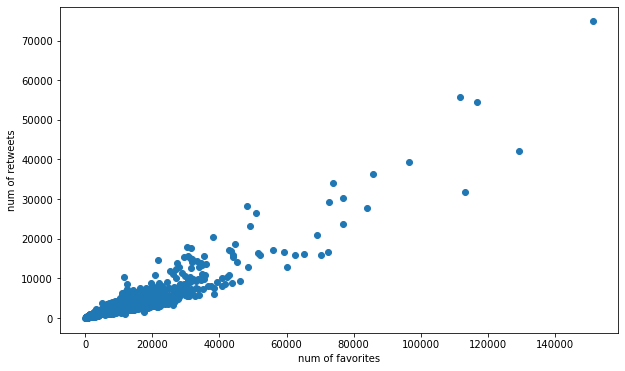

In [74]:
# Scatter plot - is there a relation between favorited tweets and the fact it's retweeted?
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = df_twitter_archive_master['favorites_cnt'], y = df_twitter_archive_master['retweets_cnt'])
plt.xlabel("num of favorites")
plt.ylabel("num of retweets")

plt.show()

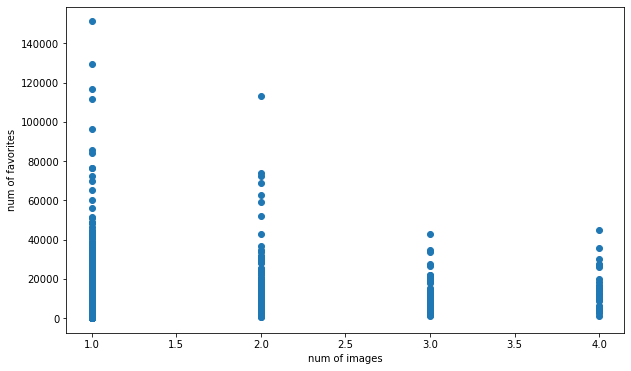

In [75]:
# scatter plot - is there a relation between num of images in picture and the fact it's favorited by users?
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = df_twitter_archive_master['img_num'], y = df_twitter_archive_master['favorites_cnt'])
plt.xlabel("num of images")
plt.ylabel("num of favorites")

plt.show()

Text(0, 0.5, 'count of tweets')

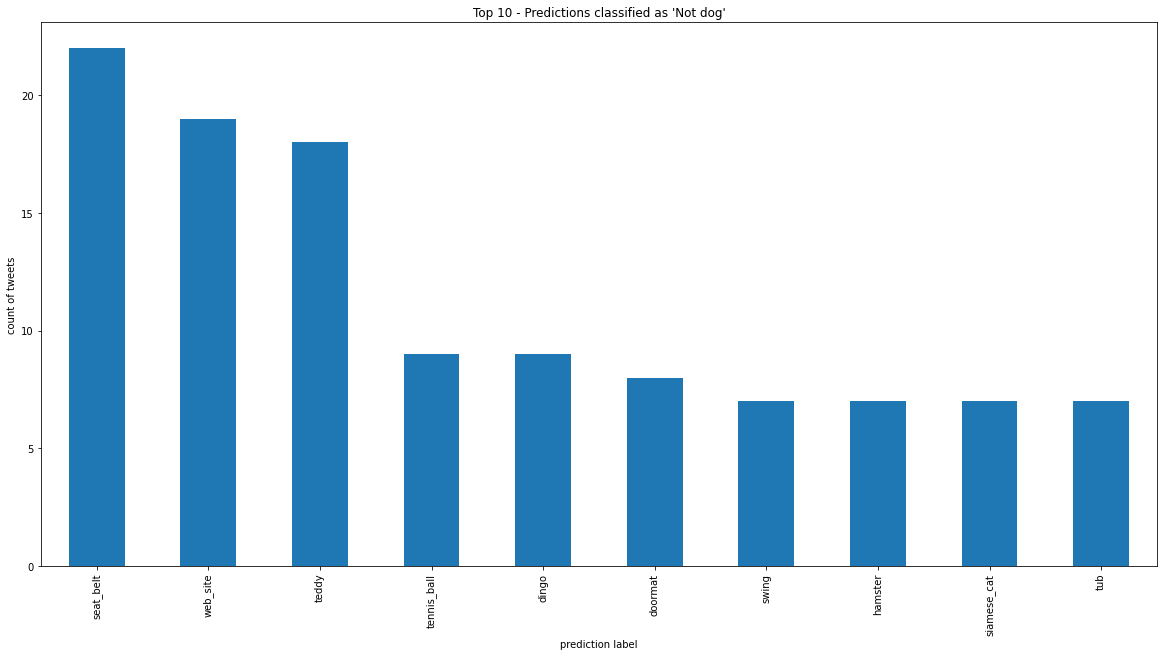

In [76]:
# Bar chart - plot predictions label for predictions classified as "not dog" (might help to improve our model)
ax = df_twitter_archive_master[(df_twitter_archive_master.preds_is_dog == False)]['predictions'].value_counts().iloc[:10]

ax1= ax.plot(kind='bar',
                                    figsize=(20,10),
                                    title="Top 10 - Predictions classified as 'Not dog'")


ax1.set_xlabel("prediction label")
ax1.set_ylabel("count of tweets")

#### Main insights:
>1. it exists a positive relationship between tweets marked as favorites and retweets \n
>2. there does not seem to be a strong and positive relation between the number of picture in a tweet the number of times it's marked as favorites - having more images to browse does not associate with greater num of favorites 1 \n
>3. analyzing the top 10 labels classified as 'not dog', one can see 'seat_belt' is ranked number one. Picture of dogs taken inside cars probably explain that and must be taken into consideration for ML model tuning.